In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.stats
#import seaborn as sns
#sns.set(style="whitegrid")
import time
import seaborn as sns; sns.set()
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy
import random

In [10]:
def Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn):
    scale_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        scale_ext[r,:eff_date] = sigma_adjust1[r]*np.ones(int(eff_date))
        scale_ext[r,eff_date:] = d*sigma_adjust2[r]*np.ones(int(nn - eff_date))
    return scale_ext

In [11]:
def C_series(eff_dates,pr1,pr2,nn):
    C_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        C_ext[r,:eff_date] = pr1*np.ones(int(eff_date))
        C_ext[r,eff_date:] = pr2*np.ones(int(nn - eff_date))
    return C_ext

In [12]:
def SEIR_Policy_relax(init_vals, C_, sigmas, p,f, params, d, eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn):
    ## input
    # nn is the number of days
    #S_0,E_0,I_0,R_0: dimension: A*R
    # C is a matrix in dimension R*R with compotnent c_(r,r')
    # p is vector in dimension A with each column equals to p_a
    S_0, E_0, I_0, A_0, D_0,R_0 = init_vals
    
    N_A, N_K = S_0.shape[0], S_0.shape[1]
      
    S, E, I, A, D, R = [S_0], [E_0], [I_0], [A_0], [D_0],[R_0]
    
    # N: total number of people in each class: matrix dimension A*R
    N = S_0 + E_0 + I_0 + R_0 +D_0+ A_0
    S_i, E_i, I_i, A_i, D_i, R_i = S_0.copy(), E_0.copy(), I_0.copy(), A_0.copy(), D_0.copy(),R_0.copy()
    alpha, beta, gamma, kappa,pi  = params
    
    sigma_home,sigma_school,sigma_work,sigma_other = sigmas
    sigma_total = sigma_home+sigma_school+sigma_work+sigma_other
    
    r1,r2,r3,r4 = relaxes
    sigma_total_2 = r1*sigma_home + r2*sigma_school + r3*sigma_work + r4*sigma_other
    C = C_
    
    ### time-dependent parameters
    scale_ts = Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn)
    C_ts = C_series(eff_dates,1.0,0.2,nn)
    
    total_cost = 0
    
    regional_real_cases = np.zeros((nn+1,N_A,N_K))
    regional_confirm_cases = np.zeros((nn+1,N_A,N_K))
    england_real_cases = np.zeros((nn+1,N_A))
    england_confirm_cases = np.zeros((nn+1,N_A))
    
    regional_real_cases[0,:,] = I_0
    england_real_cases[0] = np.sum(I_0)
    for region in range(N_K):
            for age in range(N_A):
                number = I_0[age,region]
                regional_confirm_cases[0,age,region] =  np.random.binomial(number, pi, 1)[0] 
    england_confirm_cases[0,:] = np.sum(regional_confirm_cases[0,:,:],axis=1)
    
    # signal==0 means relax policy (not control)
    # signal > 0 means control 
    signals = np.zeros(nn)
    signals[:relax_day] = 1
    mask_base = np.arange(16)
    mask = (mask_base < 4) | (mask_base > 11)
    for t in range(nn):
        day_cost = 0
        signal = signals[t]
        Lambda = np.zeros((N_A,N_K))
        if signal > 0:
            Sigma = sigma_total
            C_r = C_ts[:,t]*C_ + (1-C_ts[:,t])*np.identity(N_K)
            Lambda += np.dot(Sigma[:,mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha *(kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:])
            
            Lambda += np.dot(Sigma[:,~mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha * np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T))
            day_cost += (N * np.dot(np.reshape(np.sum(Sigma, axis=-1), (-1, 1)), np.reshape(scale_ts[:,t], (1, -1)))).flatten().sum()
            
            #for r in range(N_K):
            #    Sigma = sigma_total
            #    C_r = C_ts[r,t]*C_ + (1-C_ts[r,t])*np.identity(133)
            #    for a in range(N_A):
            #        for a_prime in [0,1,2,3,12,13,14,15]:
            #            Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
            #        for a_prime in [4,5,6,7,8,9,10,11]:
            #            Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
            #        day_cost += N[a,r] *scale_ts[r,t] *np.sum(Sigma[a,:])
        if signal ==0 :
            Sigma = sigma_total_2
            C_r = r3*C_ + (1-r3)*np.identity(133)
            scale_ts_tmp = sigma_adjust1
            Lambda += (alpha * np.dot(Sigma[:, mask], (kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:] * scale_ts_tmp.reshape((1, -1))))
            Lambda += (alpha * np.dot(Sigma[:,~mask], np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T) * scale_ts_tmp.reshape((1, -1))))
            day_cost +=  (N * np.dot(Sigma.sum(axis=-1).reshape((-1, 1)), scale_ts_tmp.reshape((1, -1)))).flatten().sum()
            
            
            #for r in range(N_K):
            #    Sigma = sigma_total_2
            #    C_r = r3*C_ + (1-r3)*np.identity(133)
            #    scale_ts_tmp = sigma_adjust1[r]
            #    for a in range(N_A):
            #        for a_prime in [0,1,2,3,12,13,14,15]:
            #            Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
            #       for a_prime in [4,5,6,7,8,9,10,11]:
            #            Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
            #        day_cost += N[a,r] *scale_ts_tmp*np.sum(Sigma[a,:])
                
        total_cost += day_cost        
        dI_i = np.zeros((N_A,N_K))
        dA_i = np.zeros((N_A,N_K))
        for a in range(N_A):
            dI_i[a,:] += p[a]*beta*E_i[a,:]
            dA_i[a,:] += (1-p[a])*beta*E_i[a,:]
        
        compartment_prob = np.array([(S_i*Lambda), dI_i, dA_i ,(gamma*f*I_i),(gamma*(1-f)*I_i),(gamma*A_i)]).reshape(6*N_A*N_K)

        compartment_prob = np.asarray(compartment_prob).astype(np.float64)
        ratio = np.sum(compartment_prob)
        if ratio > 0:
            compartment_prob /= np.sum(compartment_prob)
        else:
            total_cost += (nn-t)*day_cost 
            return S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_cost

        number_event = np.random.poisson(ratio,1)[0]
    
        ind = np.random.multinomial(number_event, compartment_prob, size=1)
        
        ind = ind.reshape(6,N_A,N_K)

        

        S_i += -ind[0,:,:]
        E_i += ind[0,:,:]-ind[1,:,:]-ind[2,:,:]
        I_i += ind[1,:,:]-ind[3,:,:]-ind[4,:,:]
        A_i += ind[2,:,:]-ind[5,:,:]
        D_i += ind[3,:,:]
        R_i += ind[4,:,:]+ind[5,:,:]
        
        S_i = (np.abs(S_i)+S_i)/2
        E_i = (np.abs(E_i)+E_i)/2
        A_i = (np.abs(A_i)+A_i)/2
        D_i = (np.abs(D_i)+D_i)/2
        I_i = (np.abs(I_i)+I_i)/2
        R_i = (np.abs(R_i)+R_i)/2
        
        regional_real_cases[t+1,:,:] = ind[1,:,:]
        england_real_cases[t+1,:] = np.sum(ind[1,:,:],axis=1)
        for region in range(N_K):
            for age in range(N_A):
                number = ind[1,age,region]
                regional_confirm_cases[t+1,age,region] =  np.random.binomial(number, pi, 1)[0] 
        
        today_confirm = np.sum(regional_confirm_cases[t+1,:,:],axis=1)
        england_confirm_cases[t+1,:] = today_confirm
        
        
        S.append(S_i.copy())
        E.append(E_i.copy())
        I.append(I_i.copy())
        A.append(A_i.copy())
        D.append(D_i.copy())
        R.append(R_i.copy())
        
        
        
        
         
    return S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_cost

# Data Preparation

In [13]:
!pwd

/Users/renyuanxu/Dropbox/Research_Codes/epidemic_code/Revision_November/pre-planned


In [14]:
contact = pd.read_csv('../../data/contact_matrix_16_groups.csv')
social_m = np.array(contact[['matrix..0.5.', 'matrix..5.10.', 'matrix..10.15.', 'matrix..15.20.',
       'matrix..20.25.', 'matrix..25.30.', 'matrix..30.35.', 'matrix..35.40.',
       'matrix..40.45.', 'matrix..45.50.', 'matrix..50.55.', 'matrix..55.60.',
       'matrix..60.65.', 'matrix..65.70.', 'matrix..70.75.', 'matrix.75.']]).reshape(16,16)


In [15]:
np.sum(social_m)

172.62456108413414

In [16]:
# social contact among age group
social_home = pd.read_csv('../../contact_matrix/POLYMOD_from_PYROSS/home_full.csv')
social_school = pd.read_csv('../../contact_matrix/POLYMOD_from_PYROSS/school_full.csv')
social_work = pd.read_csv('../../contact_matrix/POLYMOD_from_PYROSS/work_full.csv')
social_other = pd.read_csv('../../contact_matrix/POLYMOD_from_PYROSS/other_full.csv')

In [17]:
social_home = np.array(social_home)
social_school  = np.array(social_school)
social_work = np.array(social_work)
social_other = np.array(social_other)

In [18]:
Sigma_ext = np.ones((4,16,16))
Sigma_ext[0,:,:] = social_home
Sigma_ext[1,:,:] = social_school
Sigma_ext[2,:,:] = social_work
Sigma_ext[3,:,:] = social_other

In [19]:
np.sum(social_m)/np.sum(Sigma_ext)

1.1329202148212985

In [20]:
#social_home *= np.sum(social_m)/np.sum(Sigma_ext)
#social_school *= np.sum(social_m)/np.sum(Sigma_ext)
#social_work *= np.sum(social_m)/np.sum(Sigma_ext)
#social_other *= np.sum(social_m)/np.sum(Sigma_ext)

In [21]:
for a in range(16):
    social_home[a,:] *= np.sum(social_m[a,:])/np.sum(Sigma_ext[:,a,:])
    social_school[a,:] *= np.sum(social_m[a,:])/np.sum(Sigma_ext[:,a,:])
    social_work[a,:] *= np.sum(social_m[a,:])/np.sum(Sigma_ext[:,a,:])
    social_other[a,:] *= np.sum(social_m[a,:])/np.sum(Sigma_ext[:,a,:])

In [22]:
sigmas = social_home,social_school,social_work,social_other

In [23]:
np.sum(sigmas)

172.6245610841341

In [24]:
#contact mtrix
transport = pd.read_csv('../../data/CommuteMatrix-NUTS3.csv')
transport_mat = np.array(transport)[:,1:].astype(float)
C = transport_mat

In [25]:
covid_data = pd.read_csv('../../data/UK-COVID-data.csv')
covid_data_new = pd.DataFrame(columns = covid_data.columns)
region_order = list(transport['Unnamed: 0'])

In [26]:
for i in range(133):
    region = region_order[i]
    covid_data_new.loc[i] = covid_data[covid_data['id']==region].values[0]
    #covid_data_new2.loc[i] = covid_data2[covid_data2['id']==region].values[0]

In [27]:
## Sanity check
print('does all tables have the same region order:')
covid_order = list(covid_data_new['id'])
#covid_order2 = list(covid_data_new2['id'])

region_order = list(transport['Unnamed: 0'])

print(region_order==covid_order)
#print(population_order==covid_order2)

does all tables have the same region order:
True


In [28]:
## Population data validation 
population = pd.read_csv('../../data/UK-COVID-data-with_ALL_age_groups.csv')
population = population[['id', 'Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]

In [29]:
population_new = pd.DataFrame(columns = population.columns)
for i in range(133):
    region = region_order[i]
    population_new.loc[i] = population[population['id']==region].values[0]

In [30]:
N_mat2 = np.array(population_new[['Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]).T

N_mat = np.zeros((16,133))

N_mat[:15,:] = N_mat2[:15,:]

N_mat[-1,:] = np.sum(N_mat2[15:,],axis=0)
np.sum(N_mat)

56171302.0

In [31]:
## Population density
population_density = np.array(covid_data_new['population_density'])

In [32]:
initial_day = 15


In [33]:
d_table =  pd.read_csv('../../data/d1d2_effdates_initialization_final_lowratio_133regions_16agegroups.csv')
initial_covid = np.array(d_table['initialization'])

sigma_adjust1 = np.array(d_table['d_adjust1'])
sigma_adjust2 = np.array(d_table['d_adjust2'])
simulation_eff_dates = np.array(d_table['adjust_dates'])

In [34]:
N_A= 16
N_K = 133

In [35]:
real_cum_cases = np.sum(np.array(covid_data_new.iloc[0:133,(19+initial_day):113]).astype(float),axis = 0)

In [36]:
covid_data_new.iloc[0:133,(19+initial_day):113]

,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,...,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31
0,5.000000,5.000000,7.000000,10.000000,11.000000,12.000000,15.000000,15.000000,15.000000,18.000000,...,885.000000,893.000000,899.000000,906.000000,918.000000,922.000000,926.000000,929.000000,933.000000,934.000000
1,2.000000,2.000000,2.000000,3.000000,4.000000,5.000000,7.000000,9.000000,14.000000,17.000000,...,1072.000000,1072.000000,1077.000000,1083.000000,1089.000000,1093.000000,1096.000000,1099.000000,1100.000000,1103.000000
2,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,369.000000,370.000000,373.000000,376.000000,376.000000,384.000000,387.000000,388.000000,389.000000,389.000000
3,16.000000,21.000000,23.000000,31.000000,39.000000,48.000000,62.000000,75.000000,82.000000,110.000000,...,3388.000000,3388.000000,3394.000000,3396.000000,3406.000000,3420.000000,3424.000000,3430.000000,3432.000000,3435.000000
4,16.522176,17.055149,23.450830,29.846512,42.104900,55.962209,62.357890,74.616279,83.143854,97.534136,...,1170.942604,1171.475577,1171.475577,1172.541524,1172.541524,1174.140444,1175.206391,1176.805312,1180.003152,1181.069099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,7.988747,8.458674,9.868453,14.097790,18.327126,22.556463,26.315874,31.015137,35.244474,41.823442,...,621.712520,622.182446,622.652373,624.062152,624.532078,625.002004,626.411783,628.291488,629.231341,629.231341
129,29.000000,36.000000,49.000000,62.000000,78.000000,95.000000,111.000000,127.000000,144.000000,177.000000,...,1136.000000,1136.000000,1137.000000,1139.000000,1140.000000,1140.000000,1142.000000,1142.000000,1142.000000,1143.000000
130,3.165192,3.587218,5.064307,5.908359,8.018487,10.972666,12.660768,14.559884,17.936089,25.321537,...,744.242167,748.040398,749.517487,754.370782,757.958000,761.545217,764.921422,767.664589,769.352691,772.095858
131,24.342302,28.010320,34.345987,39.347830,45.016585,53.352990,63.356675,71.026168,82.697134,99.036487,...,1092.402465,1094.736658,1097.070851,1102.739607,1105.407256,1107.407993,1109.408730,1110.409099,1111.409467,1112.743292


In [37]:
real_cum_cases_ind = np.cumsum(np.ones(len(real_cum_cases)))+initial_day

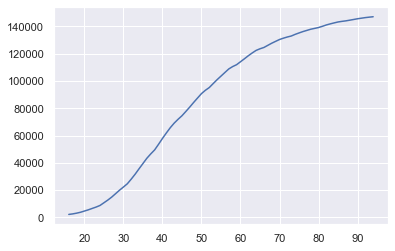

In [38]:
plt.plot(real_cum_cases_ind,real_cum_cases)

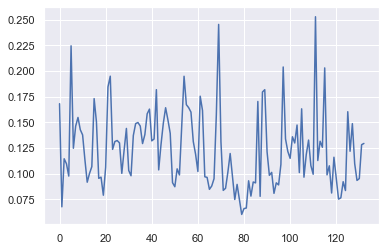

In [39]:
plt.plot(0.12*sigma_adjust2/sigma_adjust1)

In [40]:
death_data = pd.read_csv('../../data/coronavirus-deaths_0615.csv')

cum_death_number = np.array(death_data[death_data['Area name']=='England'][::-1].iloc[9:]['Cumulative deaths'])

cum_death_number_ind = np.cumsum(np.ones(len(cum_death_number)))+initial_day

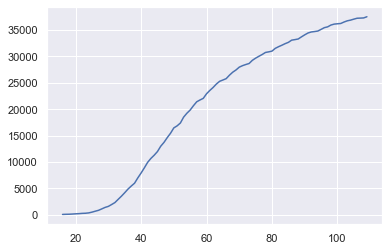

In [41]:
plt.plot(cum_death_number_ind,cum_death_number)

# Initialization

In [42]:
alpha = 0.055 #+ np.random.normal(0, 0.01, 1)[0]
beta = 0.2 #+ np.random.normal(0, 0.05, 1)[0]
gamma = 0.1 #+ np.random.normal(0, 0.02, 1)[0]
kappa = 0.5 # + np.random.normal(0, 0.05, 1)[0]

f0 = 0.002 
f1 = 0.002
f2 = 0.01
f3 = 0.01
f4 = 0.05
f5 = 0.05
f6 = 0.1
f7 = 0.1
f8 =  0.2
f9 = 0.2
f10 = 0.6
f11 = 0.6
f12 = 2.0
f13 = 2.0
f14 = 4.0
f15 = 7.5 

p0 = 0.075 
p1 =  0.075
p2 = 0.05
p3 = 0.05
p4 = 0.15
p5 = 0.15
p6 = 0.21
p7 = 0.21
p8 =  0.23 
p9 = 0.23 
p10 = 0.28
p11 = 0.28
p12 =  0.41
p13 =  0.41
p14 =  0.375
p15 = 0.375
p = [p0,p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15]
pi = 4.5/100
# 0.005,0.25,2,6
f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi

In [43]:
## initial population
init_sick = np.zeros((N_A,N_K))
init_sick_scale = np.zeros((N_A,N_K))
for a in [4,5,6,7,8,9,10,11]:
    init_sick[a,:] = initial_covid*(N_mat[a,:])/np.sum(N_mat[4:12,:],axis=0)

for a in [4,5,6,7,8,9,10,11]:
    init_sick_scale[a,:] = init_sick[a,:]/(p[a]*pi)
#init_sick[1,44] = 5
#init_sick[1,64] = 5
init_vals = N_mat-(init_sick_scale).astype(int),(init_sick_scale).astype(int), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K))

In [44]:
N_mat.shape

(16, 133)

In [45]:
sigmas_total = social_home+social_school+social_work+social_other

In [46]:
np.sum(sigmas_total)

172.6245610841341

In [47]:
nn = 1000

In [48]:
benchmark_total_contact = 0
for r in range(133):
    for a in range(16):
        benchmark_total_contact += N_mat[a,r]*sigma_adjust1[r]*nn*np.sum(sigmas_total[a,:])

In [49]:
benchmark_total_contact

613800527142.0557

# Experiments

In [50]:
sns.set(font_scale=1.3)

In [51]:
scale = 0.12

In [52]:
# in the order of home, school, work, others
# this will be multipled to the matrix before lockdown
relaxes = 1, 0.0 , 1.0, 0.5
relax_day = 120
nn = 1000
S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases,total_contact =SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)


In [53]:
benchmark_total_contact - total_contact

223578633708.17407

In [54]:
total_contact

390221893433.8816

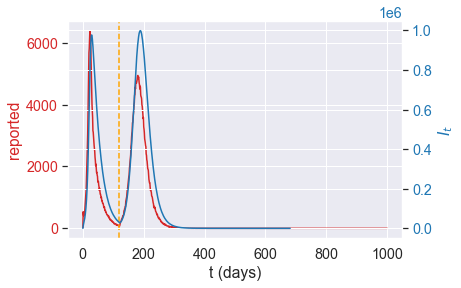

In [55]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('t (days)')
ax1.set_ylabel('reported', color=color)
ax1.plot(np.sum(england_confirm_cases,axis=1), color=color)
ax1.axvline(x=relax_day,ls="--",color='orange',alpha=1)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
color2 = 'tab:green'
ax2.set_ylabel(r'$I_t$', color=color)  # we already handled the x-label with ax1
ax2.plot(np.sum(np.array(I),axis=(1,2)), color=color)
#ax2.plot(np.sum(np.array(A),axis=(1,2)), color=color2)
ax2.tick_params(axis='y', labelcolor=color)
#plt.savefig("results/openloop_multisigma/"+"I"+"_"+str(relaxes)+"_"+str(relax_day)+".png",bbox_inches="tight")

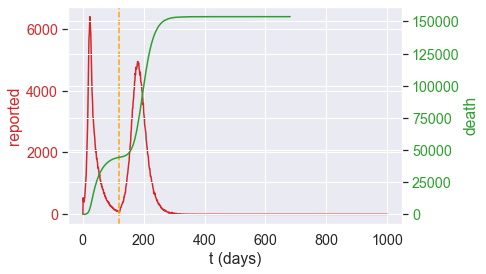

In [56]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('t (days)')
ax1.set_ylabel('reported', color=color)
ax1.plot(np.sum(england_confirm_cases,axis=1), color=color)
ax1.axvline(x=relax_day,ls="--",color='orange',alpha=1)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
color2 = 'tab:green'
ax2.set_ylabel('death', color=color2)  # we already handled the x-label with ax1
ax2.plot(np.sum(np.array(D),axis=(1,2)), color=color2)
#ax2.plot(np.sum(np.array(A),axis=(1,2)), color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
#plt.savefig("results/openloop_multisigma/"+"death"+"_"+str(relaxes)+"_"+str(relax_day)+".png",bbox_inches="tight")

In [57]:
I = np.array(I)

In [58]:
I.shape

(682, 16, 133)

In [59]:
r= 65

In [60]:
region_order[r]

'UKH35'

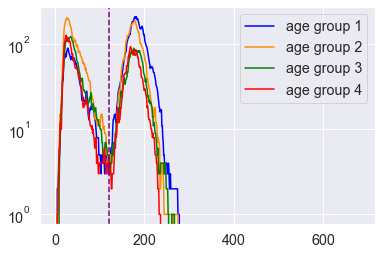

In [61]:
plt.plot(I[:,0,r],label='age group 1',color='blue')
plt.plot(I[:,1,r],label='age group 2',color='darkorange')
plt.plot(I[:,2,r],label='age group 3',color='green')
plt.plot(I[:,3,r],label='age group 4',color='red')
plt.axvline(x=relax_day,ls="--",color='purple',alpha=1)
plt.yscale('log')
plt.legend()
#plt.savefig("results/openloop_multisigma/"+region_order[r]+"_"+str(relaxes)+"_"+str(relax_day)+".png",bbox_inches="tight")

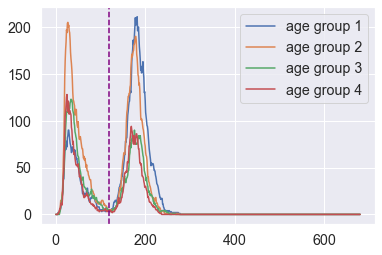

In [62]:
plt.plot(I[:,0,r],label='age group 1')
plt.plot(I[:,1,r],label='age group 2')
plt.plot(I[:,2,r],label='age group 3')
plt.plot(I[:,3,r],label='age group 4')
plt.axvline(x=relax_day,ls="--",color='purple',alpha=1)
plt.legend()


# Improvements along the frontier

## 1

In [64]:
r1,r2,r3,r4 = 1, 0.0 , 0.2, 1.0
nn = 1000
paths =  5

relaxes = r1,r2,r3,r4
relax_day = 120
Trags = np.zeros((nn+1,paths))
Deaths = np.zeros((nn+1,paths))
Trags_I = np.zeros((nn+1,paths))
Costs = np.zeros(paths)

Deaths_total = np.zeros(paths)
I_all = np.zeros((nn+1,16,133,paths))

for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
   
    cost = benchmark_total_contact -  total_contact                             
    lenss = np.array(I).shape[0]
              
    I_all[:lenss,:,:,path] = np.array(I)              
                    
    
    Costs[path] = cost   
    Deaths_total[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4


In [65]:
I_mean = np.mean(Trags_I,axis=1)
I_std = np.std(Trags_I,axis=1)

D_mean = np.mean(Deaths,axis=1)
D_std = np.std(Deaths,axis=1)

lag = 10

xx = np.cumsum(np.ones(len(D_mean)))-1+lag

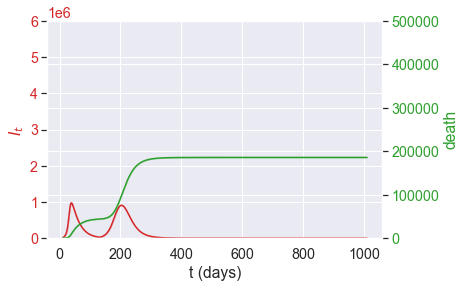

In [66]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('t (days)')
ax1.set_ylabel('$I_t$', color=color)
ax1.plot(xx,I_mean, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.fill_between(xx,I_mean+I_std,I_mean-I_std,alpha=0.2,color=color)

ax1.set_ylim([0,6000000])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:green'
ax2.set_ylabel('death', color=color2)  # we already handled the x-label with ax1
ax2.plot(xx,D_mean, color=color2)
ax2.fill_between(xx,D_mean+D_std,D_mean-D_std,alpha=0.2,color=color2)
ax2.set_ylim([0,500000])
#ax2.plot(np.sum(np.array(A),axis=(1,2)), color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
#plt.savefig("results/openloop_multisigma/frontier/multisigna_school_frontier1.png",bbox_inches="tight")

## 2

In [67]:
r1,r2,r3,r4 = 1,0.5,1.0,0.1
nn = 1000
paths = 5

relaxes = r1,r2,r3,r4
relax_day = 180
Trags2 = np.zeros((nn+1,paths))
Deaths2 = np.zeros((nn+1,paths))
Trags_I2 = np.zeros((nn+1,paths))
Costs2 = np.zeros(paths)

Deaths_total2 = np.zeros(paths)
I_all2 = np.zeros((nn+1,16,133,paths))

for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
    end = nn+1
                                                 
    lenss = np.array(I).shape[0]
              
    I_all2[:lenss,:,:,path] = np.array(I)              
                    
    cost = benchmark_total_contact -  total_contact   
    Costs2[path] = cost   
    Deaths_total2[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags2[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I2[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths2[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths2[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4


In [68]:
I_mean2 = np.mean(Trags_I2,axis=1)
I_std2 = np.std(Trags_I2,axis=1)

D_mean2 = np.mean(Deaths2,axis=1)
D_std2 = np.std(Deaths2,axis=1)

lag = 10

xx = np.cumsum(np.ones(len(D_mean)))-1+lag

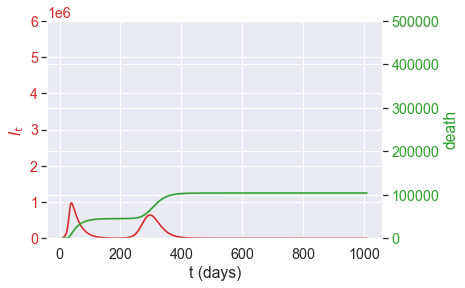

In [69]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('t (days)')
ax1.set_ylabel('$I_t$', color=color)
ax1.plot(xx,I_mean2, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.fill_between(xx,I_mean2+I_std2,I_mean2-I_std2,alpha=0.2,color=color)

ax1.set_ylim([0,6000000])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:green'
ax2.set_ylabel('death', color=color2)  # we already handled the x-label with ax1
ax2.plot(xx,D_mean2, color=color2)
ax2.fill_between(xx,D_mean2+D_std2,D_mean2-D_std2,alpha=0.2,color=color2)
ax2.set_ylim([0,500000])
#ax2.plot(np.sum(np.array(A),axis=(1,2)), color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
#plt.savefig("results/openloop_multisigma/frontier/multisigna_school_frontier2.png",bbox_inches="tight")

In [70]:
np.mean(Costs2)

287977585016.6256

## 3

In [71]:
r1,r2,r3,r4 = 1,1.0,0.8, 1.0
nn = 1000
paths = 5

relaxes = r1,r2,r3,r4
relax_day = 90
Trags3 = np.zeros((nn+1,paths))
Deaths3 = np.zeros((nn+1,paths))
Trags_I3 = np.zeros((nn+1,paths))
Costs3 = np.zeros(paths)

Deaths_total3 = np.zeros(paths)
I_all3 = np.zeros((nn+1,16,133,paths))

for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
    end = nn+1
                                             
    lenss = np.array(I).shape[0]
              
    I_all3[:lenss,:,:,path] = np.array(I)              
                    
    cost = benchmark_total_contact -  total_contact   
    Costs3[path] = cost   
    Deaths_total3[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags3[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I3[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths3[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths3[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4


In [72]:
I_mean3 = np.mean(Trags_I3,axis=1)
I_std3 = np.std(Trags_I3,axis=1)

D_mean3 = np.mean(Deaths3,axis=1)
D_std3 = np.std(Deaths3,axis=1)

lag = 10

xx = np.cumsum(np.ones(len(D_mean)))-1+lag

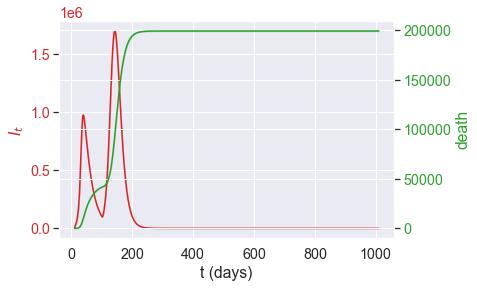

In [73]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('t (days)')
ax1.set_ylabel('$I_t$', color=color)
ax1.plot(xx,I_mean3, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.fill_between(xx,I_mean3 + I_std3,I_mean3 - I_std3,alpha=0.2,color=color)

#ax1.set_ylim([0,6000000])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:green'
ax2.set_ylabel('death', color=color2)  # we already handled the x-label with ax1
ax2.plot(xx,D_mean3, color=color2)
ax2.fill_between(xx,D_mean3 + D_std3, D_mean3- D_std3,alpha=0.2,color=color2)
#ax2.set_ylim([0,500000])
#ax2.plot(np.sum(np.array(A),axis=(1,2)), color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
#plt.savefig("results/openloop_multisigma/frontier/multisigna_school_frontier3.png",bbox_inches="tight")

# 4

In [112]:
r1,r2,r3,r4 = 1.0,1.0,0.2, 0.3 # 1, 0.0 , 0.2, 1.0
nn = 1000
paths = 5

relaxes = r1,r2,r3,r4
relax_day = 120
Trags4 = np.zeros((nn+1,paths))
Deaths4 = np.zeros((nn+1,paths))
Trags_I4 = np.zeros((nn+1,paths))
Costs4 = np.zeros(paths)

Deaths_total4 = np.zeros(paths)
I_all4 = np.zeros((nn+1,16,133,paths))

for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
    end = nn+1
                                             
    lenss = np.array(I).shape[0]
              
    I_all4[:lenss,:,:,path] = np.array(I)              
                    
    cost = benchmark_total_contact -  total_contact   
    Costs4[path] = cost   
    Deaths_total4[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags4[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I4[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths4[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths4[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4


In [113]:
I_mean4 = np.mean(Trags_I4,axis=1)
I_std4 = np.std(Trags_I4,axis=1)

D_mean4 = np.mean(Deaths4,axis=1)
D_std4 = np.std(Deaths4,axis=1)

lag = 10

xx = np.cumsum(np.ones(len(D_mean)))-1+lag

In [114]:
print(np.mean(Costs),np.mean(Costs4))

228656869288.3001 301921405645.2014


In [115]:
print(np.mean(Deaths_total),np.mean(Deaths_total4))

185840.6 119055.6


In [116]:
(185840.6-118683.8)/185840.6

0.36136775279459926

In [117]:
(np.mean(Deaths_total)-np.mean(Deaths_total4))/np.mean(Deaths_total)

0.359367113537085

In [118]:
(np.mean(Deaths_total) -np.mean(Deaths_total4))/np.mean(Deaths_total)

0.359367113537085

In [119]:
sns.set(font_scale=1.3)

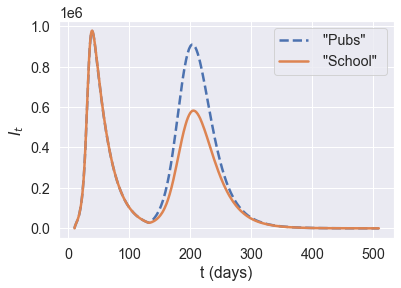

In [120]:
plt.plot(xx[:500],I_mean[:500], label= ' "Pubs" ',linewidth = 2.5,linestyle='--')
plt.plot(xx[:500],I_mean4[:500],label= ' "School" ',linewidth = 2.5)
#plt.plot(xx,I_mean4,label= " ",linewidth = 2.5)
plt.legend()
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.savefig('results/multisigma_comparison_It_lowratio.png',bbox_inches="tight")

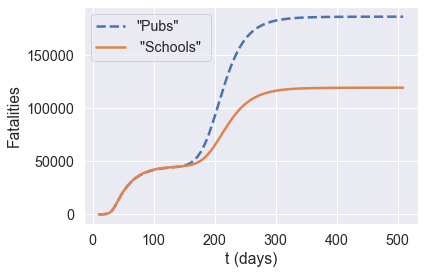

In [121]:
plt.plot(xx[:500],D_mean[:500], label= '"Pubs"',linewidth = 2.5,linestyle='--')
plt.plot(xx[:500],D_mean4[:500],label= ' "Schools" ',linewidth = 2.5)
#plt.plot(xx,D_mean3,label= " ",linewidth = 2.5)
plt.legend()
plt.xlabel('t (days)')
plt.ylabel('Fatalities')
plt.savefig('results/multisigma_comparison_Dt_lowratio.png',bbox_inches="tight")

In [82]:
region = 89

In [83]:
region_order[region]

'UKJ14'

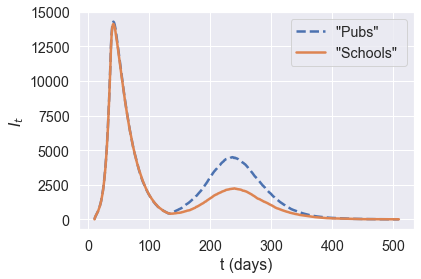

In [84]:
plt.plot(xx[:500],np.mean(np.sum(I_all,axis=1),axis=2)[:500,region],linewidth=2.5, label = '"Pubs" ' ,linestyle="--" )
plt.plot(xx[:500],np.mean(np.sum(I_all4,axis=1),axis=2)[:500,region],linewidth=2.5, label = '"Schools" ')
#plt.plot(np.mean(np.sum(I_all3,axis=1),axis=2)[:,region],linewidth=2.5, label = " ")
plt.legend()
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.savefig('results/multisigma_comparison_UKJ14_lowratio.png',bbox_inches="tight")

# Impact of School Closure

In [85]:
r1,r2,r3,r4 = 1.0, 0.0 , 1.0, 0.5
nn = 1000
paths =  10

relaxes = r1,r2,r3,r4
relax_day = 120


Trags4 = np.zeros((nn+1,paths))
Deaths4 = np.zeros((nn+1,paths))
Trags_I4 = np.zeros((nn+1,paths))
Costs4 = np.zeros(paths)

Deaths_total4 = np.zeros(paths)
I_all4 = np.zeros((nn+1,16,133,paths))

for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
   
    cost = benchmark_total_contact -  total_contact                             
    lenss = np.array(I).shape[0]
              
    I_all4[:lenss,:,:,path] = np.array(I)              
                    
    
    Costs4[path] = cost   
    Deaths_total4[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags4[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I4[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths4[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths4[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4
5
6
7
8
9


In [86]:
r1,r2,r3,r4 = 1, 0.5 , 1.0, 0.5
nn = 1000
paths =  10

relaxes = r1,r2,r3,r4
relax_day = 120


Trags5 = np.zeros((nn+1,paths))
Deaths5 = np.zeros((nn+1,paths))
Trags_I5 = np.zeros((nn+1,paths))
Costs5 = np.zeros(paths)

Deaths_total5 = np.zeros(paths)
I_all5 = np.zeros((nn+1,16,133,paths))

for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
   
    cost = benchmark_total_contact -  total_contact                             
    lenss = np.array(I).shape[0]
              
    I_all5[:lenss,:,:,path] = np.array(I)              
                    
    
    Costs5[path] = cost   
    Deaths_total5[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags5[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I5[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths5[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths5[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4
5
6
7
8
9


In [87]:
r1,r2,r3,r4 = 1, 1.0 , 1.0, 0.5
nn = 1000
paths =  10

relaxes = r1,r2,r3,r4
relax_day = 120


Trags6 = np.zeros((nn+1,paths))
Deaths6 = np.zeros((nn+1,paths))
Trags_I6 = np.zeros((nn+1,paths))
Costs6 = np.zeros(paths)

Deaths_total6 = np.zeros(paths)
I_all6 = np.zeros((nn+1,16,133,paths))

for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
   
    cost = benchmark_total_contact -  total_contact                             
    lenss = np.array(I).shape[0]
              
    I_all6[:lenss,:,:,path] = np.array(I)              
                    
    
    Costs6[path] = cost   
    Deaths_total6[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags6[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I6[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths6[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths6[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4
5
6
7
8
9


In [88]:
I_mean4 = np.mean(Trags_I4,axis=1)
I_std4 = np.std(Trags_I4,axis=1)

D_mean4 = np.mean(Deaths4,axis=1)
D_std4 = np.std(Deaths4,axis=1)

In [89]:
I_mean5 = np.mean(Trags_I5,axis=1)
I_std5 = np.std(Trags_I5,axis=1)

D_mean5 = np.mean(Deaths5,axis=1)
D_std5 = np.std(Deaths5,axis=1)

In [90]:
I_mean6 = np.mean(Trags_I6,axis=1)
I_std6 = np.std(Trags_I6,axis=1)

D_mean6 = np.mean(Deaths6,axis=1)
D_std6 = np.std(Deaths6,axis=1)

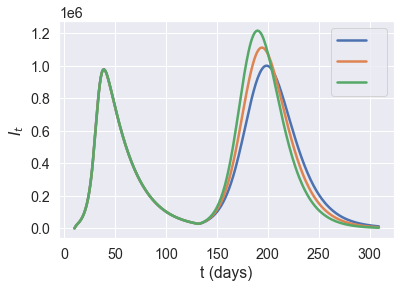

In [91]:
plt.plot(xx[:300],I_mean4[:300], label= " ",linewidth = 2.5)
plt.plot(xx[:300],I_mean5[:300],label= " ",linewidth = 2.5)
plt.plot(xx[:300],I_mean6[:300],label= " ",linewidth = 2.5)
plt.legend()
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.savefig('results/multisigma_comparison_school_It_lowratio.png',bbox_inches="tight")

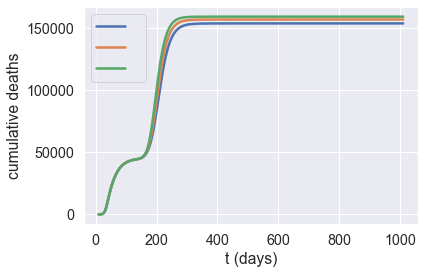

In [92]:
plt.plot(xx,D_mean4, label= " ",linewidth = 2.5)
plt.plot(xx,D_mean5,label= " ",linewidth = 2.5)
plt.plot(xx,D_mean6,label= " ",linewidth = 2.5)
plt.legend()
plt.xlabel('t (days)')
plt.ylabel(r'cumulative deaths')
plt.savefig('results/multisigma_comparison_school_Dt_lowratio.png',bbox_inches="tight")

In [93]:
print(np.mean(Costs4),np.mean(Costs5),np.mean(Costs6))
print(np.mean(Deaths_total4),np.mean(Deaths_total5),np.mean(Deaths_total6))

223578633708.17426 188886662815.6701 154194691923.1593
153878.2 156999.8 159303.4


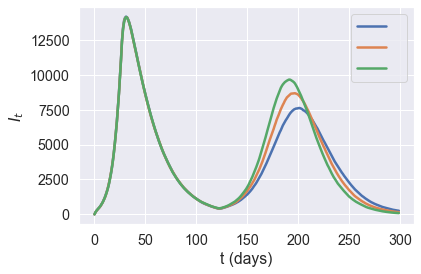

In [94]:
plt.plot(np.mean(np.sum(I_all4,axis=1),axis=2)[:300,region],linewidth=2.5, label = " ")
plt.plot(np.mean(np.sum(I_all5,axis=1),axis=2)[:300,region],linewidth=2.5, label = " ")
plt.plot(np.mean(np.sum(I_all6,axis=1),axis=2)[:300,region],linewidth=2.5, label = " ")
plt.legend()
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.savefig('results/multisigma_comparison_school_UKJ14_lowratio.png',bbox_inches="tight")

# Shielding

In [95]:
data_shielding = pd.read_csv('results/shielding_result_for_comparison.csv')

In [96]:
I_mean4_sheilding = np.array(data_shielding['I_t'])
D_mean4_sheilding = np.array(data_shielding['D_t'])

In [97]:
lag = 10
xx = np.cumsum(np.ones(len(D_mean4)))-1+lag

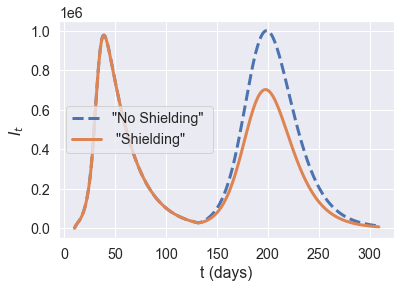

In [98]:
plt.plot(xx[:300],I_mean4[:300],linewidth=3, label = '"No Shielding" ',linestyle='--')
plt.plot(xx[:300],I_mean4_sheilding[:300],linewidth=3, label =  ' "Shielding" ')
plt.xlabel('t (days)')
plt.ylabel(r'$I_t$')
plt.legend()
plt.savefig('results/multisigma_comparison_sheilding_It_lowratio.png',bbox_inches="tight")

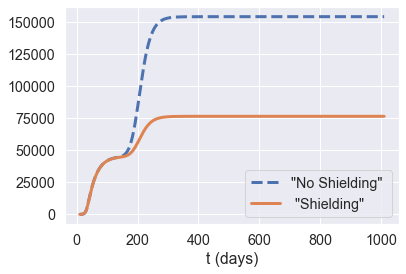

In [99]:
plt.plot(xx,D_mean4,linewidth=3, label = '"No Shielding" ',linestyle='--')
plt.plot(xx,D_mean4_sheilding,linewidth=3, label = ' "Shielding" ')
plt.xlabel('t (days)')
plt.legend()
plt.savefig('results/multisigma_comparison_shielding_Dt_lowratio.png',bbox_inches="tight")

In [100]:
np.mean(Costs4)

223578633708.17426

In [101]:
D_mean4[-1]

153878.2

In [102]:
D_mean4_sheilding[-1]

76321.3

# Mega comparison

In [122]:
r1,r2,r3,r4 = 1, 0.5 , 0.5, 0.3
nn = 1000
paths =  10

relaxes = r1,r2,r3,r4
relax_day = 120


Trags7 = np.zeros((nn+1,paths))
Deaths7 = np.zeros((nn+1,paths))
Trags_I7 = np.zeros((nn+1,paths))
Costs7 = np.zeros(paths)

Deaths_total7 = np.zeros(paths)
I_all7 = np.zeros((nn+1,16,133,paths))
A_all7 = np.zeros((nn+1,16,133,paths))
for path in range(paths):
    print(path)
                
                   
    S,E,I,A,D,R,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact = SEIR_Policy_relax(init_vals, C, sigmas,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relaxes,relax_day,nn)
   
    cost = benchmark_total_contact -  total_contact                             
    lenss = np.array(I).shape[0]
              
    I_all7[:lenss,:,:,path] = np.array(I)              
    A_all7[:lenss,:,:,path] = np.array(A)                      
    
    Costs7[path] = cost   
    Deaths_total7[path] = np.sum(np.array(D),axis=(1,2))[-1]
        
        
    
    Trags7[:,path] = np.sum(england_confirm_cases,axis=1)
    Trags_I7[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    Deaths7[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    Deaths7[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]

0
1
2
3
4
5
6
7
8
9


In [123]:
np.mean(Deaths7,axis=1)[155-lag]

45526.3

In [124]:
np.mean(Deaths7,axis=1)[-1]

122881.1

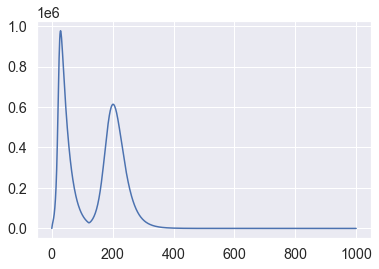

In [125]:
plt.plot(np.mean(np.sum(I_all7,axis=(1,2)),axis=1))

In [126]:
np.mean(np.sum(I_all7,axis=(1,2)),axis=1)[155-lag]

84711.6

In [127]:
np.max(np.mean(np.sum(I_all7,axis=(1,2)),axis=1)[100:])

613283.8

In [128]:
np.mean(np.sum(A_all7,axis=(1,2)),axis=1)[155-lag]

360137.9

In [129]:
np.max(np.mean(np.sum(A_all7,axis=(1,2)),axis=1)[100:])

2280806.0

In [130]:
I_all7.shape

(1001, 16, 133, 10)

In [210]:

I_ext_region_37 = I_all7[:,:,37,:]

I_ext_region_48 =  I_all7[:,:,48,:]

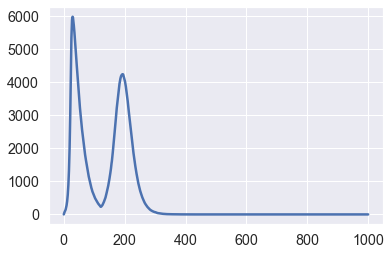

In [211]:
plt.plot(np.sum(np.mean(I_ext_region_37,axis=-1),axis=1),linewidth=2.5)


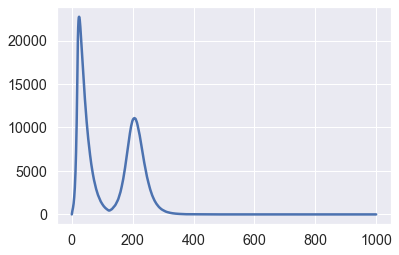

In [212]:
plt.plot(np.sum(np.mean(I_ext_region_48,axis=-1),axis=1),linewidth=2.5)


In [213]:
np.mean(Costs7)

293426943696.25977

In [214]:
a = np.sum(np.mean(I_ext_region_37,axis=-1),axis=1)

In [215]:
b = np.sum(np.mean(I_ext_region_48,axis=-1),axis=1)

In [216]:
data = {"leicester":a,"birmingham":b}

In [217]:
data = pd.DataFrame(data)

In [218]:
data.to_csv('openloop_regions.csv',index=False)